# EDA: Label-Based Insight

This EDA is based on the newly generated labels: sentiment_label, conversation_stage, and response_type. General EDA can be found in EDA.ipynb.

**Sections**
* Label Distributions
* Label Interactions
* Label and Speaker Analysis
* Label Trends by Turn Position
* Sentiment Analysis
* Common Words per Label
* Summary

In [130]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re

In [26]:
# Dataset generated in label_generation.ipynb
df = pd.read_csv("../data/processed/labeled_sequential_convos.csv")
df.head()

,conversation_id,turn,speaker,text,sentiment_score,sentiment_label,conversation_stage,response_type
0,0,0,Customer,"Hi, Im interested in purchasing a new smartph...",0.8625,positive,Introduction,Question
1,1,0,Customer,"Hi, Im interested in learning more about your...",0.4019,positive,Introduction,Other
2,2,0,Customer,"Hi, Im interested in investing in the stock m...",0.6597,positive,Introduction,Question
3,3,0,Customer,"Hello, Im interested in your financial planni...",0.4019,positive,Introduction,Other
4,4,0,Customer,"Hi, Im interested in purchasing a new laptop....",0.6597,positive,Introduction,Question


## Label Distributions

### sentiment_label

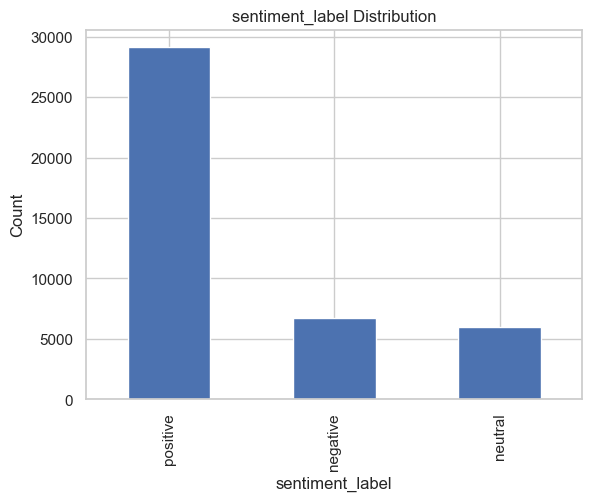

In [47]:
df['sentiment_label'].value_counts().plot(kind='bar')
plt.title("sentiment_label Distribution")
plt.ylabel("Count")
plt.show()

In [53]:
# Percentages of each label to check class imbalance
df['sentiment_label'].value_counts(normalize=True) * 100

sentiment_label
positive    69.591915
negative    16.137048
neutral     14.271037
Name: proportion, dtype: float64

There is a large proportion of positive sentiment, which may indicate a customer service trend in the dataset.

### conversation_stage

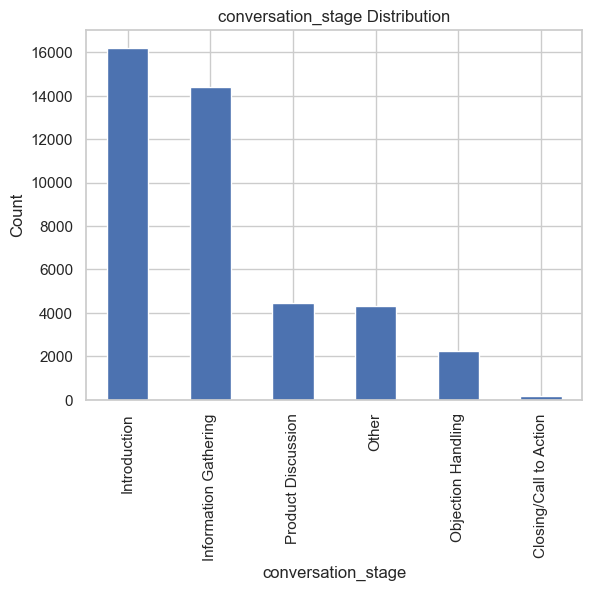

In [48]:
df['conversation_stage'].value_counts().plot(kind='bar')
plt.title("conversation_stage Distribution")
plt.ylabel("Count")
plt.show()

In [54]:
# Percentages of each label to check class imbalance
df['conversation_stage'].value_counts(normalize=True) * 100

conversation_stage
Introduction              38.748985
Information Gathering     34.457877
Product Discussion        10.665647
Other                     10.331151
Objection Handling         5.375830
Closing/Call to Action     0.420509
Name: proportion, dtype: float64

There are high proportions of the Introduction and Information Gathering stages. Conversely, there is a low proportion of Closing/Call to Action snippets. This may indicate that most of the sales conversations are not successful.

### response_type

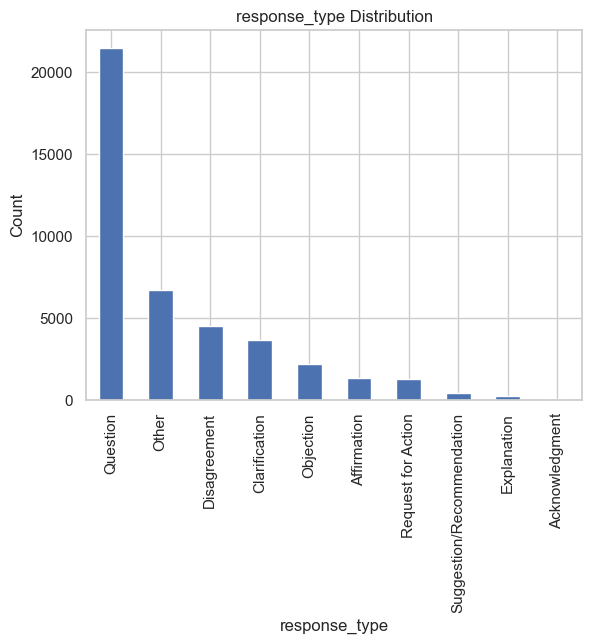

In [49]:
df['response_type'].value_counts().plot(kind='bar')
plt.title("response_type Distribution")
plt.ylabel("Count")
plt.show()

In [55]:
# Percentages of each label to check class imbalance
df['response_type'].value_counts(normalize=True) * 100

response_type
Question                     51.294978
Other                        16.034310
Disagreement                 10.777942
Clarification                 8.775744
Objection                     5.256367
Affirmation                   3.206384
Request for Action            3.027190
Suggestion/Recommendation     0.981985
Explanation                   0.594925
Acknowledgment                0.050174
Name: proportion, dtype: float64

There is a high proportion of the Question type, indicating that the dataset contains significant inquiry-based interactions and is a key part of the conversation flow. This may be the customer seeking more information or the salesman trying to identify the customer's needs.

___

## Label Interactions

### conversation_stage vs. response_type

Heatmap to help identify common response types in each conversation stage, displaying the frequency of each response type within each conversation stage.

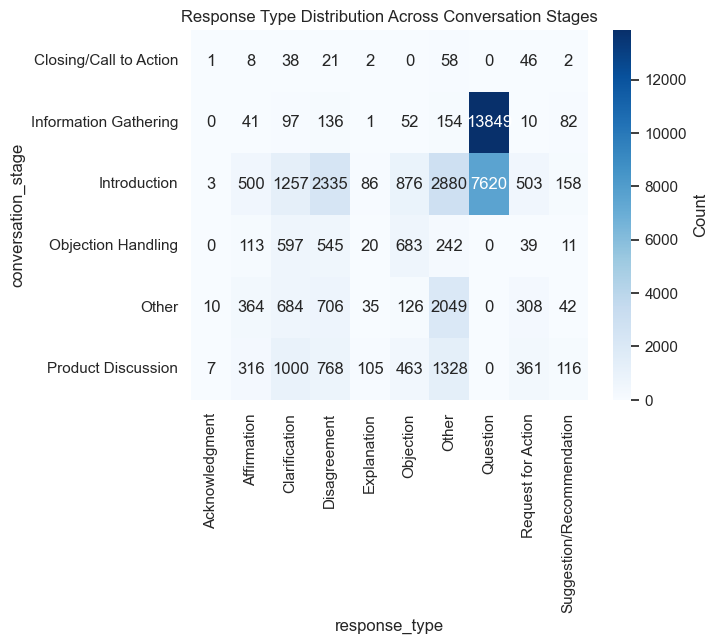

In [66]:
conversation_response_ct = pd.crosstab(df['conversation_stage'], df['response_type'])
sns.heatmap(conversation_response_ct, annot=True, fmt="d", cmap="Blues", cbar_kws={'label': 'Count'})
plt.title("Response Type Distribution Across Conversation Stages")
plt.show()

Stacked bar chart: An alternate view of how response_type varies across conversation_stage.

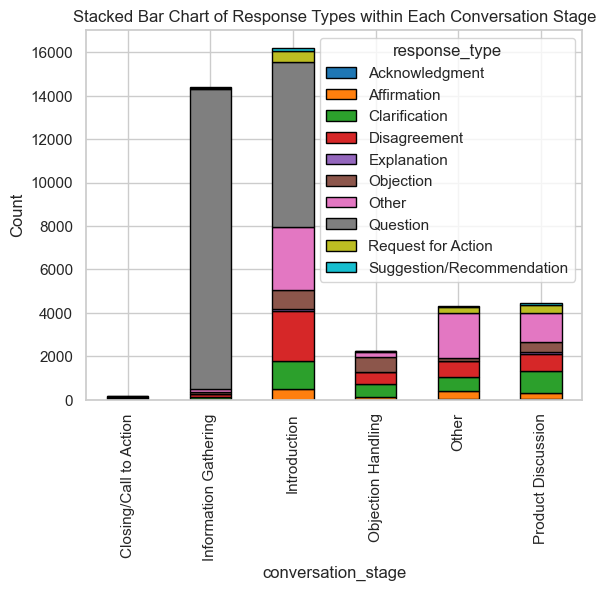

In [95]:
conversation_response_ct.plot(kind='bar', stacked=True, colormap="tab10", edgecolor="black")#, figsize=(12, 8))
plt.title("Stacked Bar Chart of Response Types within Each Conversation Stage")
plt.ylabel("Count")
plt.show()

**Observations**
* There is a dominance of Question in Information Gathering. This aligns with the stage's purpose of exploring details and asking for clarifications.
    * This also reinforces that the labeling captures the intended conversation dynamics for this stage.
* The Introduction stage is diverse, containing varied type. This suggests that the stage serves multiple purposes, which may be greetings, initial queries, or acknowledgments.
* Objection Handling and Product Discussion show similar patterns by both containing notable amounts of Objection, Disagreement, and Clarification response types. This reflects their role in resolving doubts and discussing details.
* The Other stage is very distributed across different response types.
* Acknowledgment, Suggestion/Recommendation, and Request for Action are somewhat more rare across all conversation stages. This may impact analysis or modeling of these types.

### sentiment_label vs. conversation_stage
Heatmap to display the sentiment distribution within each stage, indicating if specific sentiments are associated with specific stages.

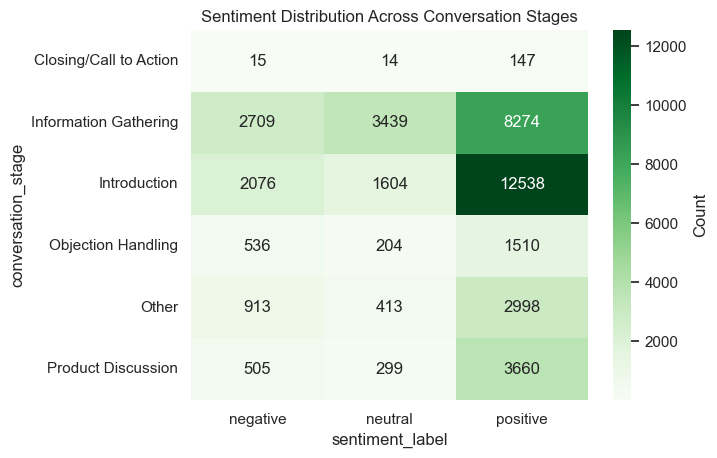

In [87]:
sentiment_conv_ct = pd.crosstab(df['conversation_stage'], df['sentiment_label'])
sns.heatmap(sentiment_conv_ct, annot=True, fmt="d", cmap="Greens", cbar_kws={'label': 'Count'})
plt.title("Sentiment Distribution Across Conversation Stages")
plt.show()

Stacked bar chart: An alternate view of how sentiment_label varies across conversation_stage

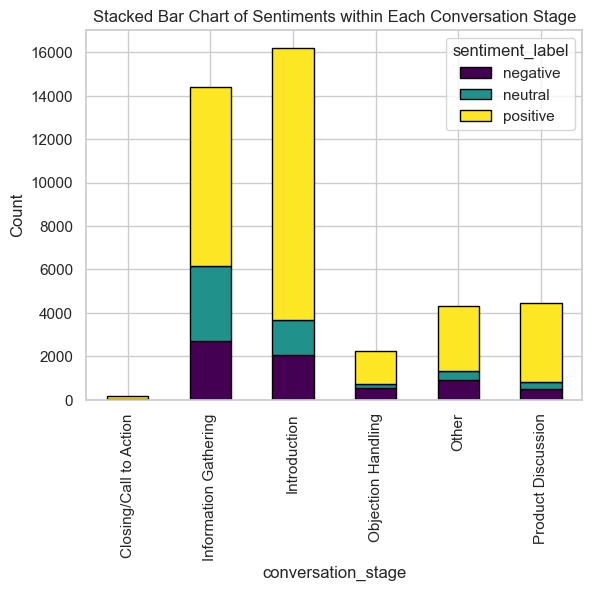

In [94]:
sentiment_conv_ct.plot(kind='bar', stacked=True, colormap="viridis", edgecolor="black")#, figsize=(12, 8))
plt.title("Stacked Bar Chart of Sentiments within Each Conversation Stage")
plt.ylabel("Count")
plt.show()

**Observations**
* Positive sentiment is prevalent across all conversation stages, especially in Introduction and Information Gathering. This makes sense due to its high proportion across the entire dataset.
* Neutral sentiment is relatively high in Information Gathering. This indicates that this stage often involves factual or objective exchanges.
* Information Gathering also has the highest negative sentiment count, which may indicate moments of dissatisfaction or challenges in understanding.
* Closing/Call to Action has the least sentiment labels. This makes sense due to its small representation in the dataset.
* Product Discussion has a relatively balanced distribution.

___

## Label and Speaker Analysis

### response_type by Speaker
Stacked bar chart: How frequently each response_type is used by Customer vs Salesman

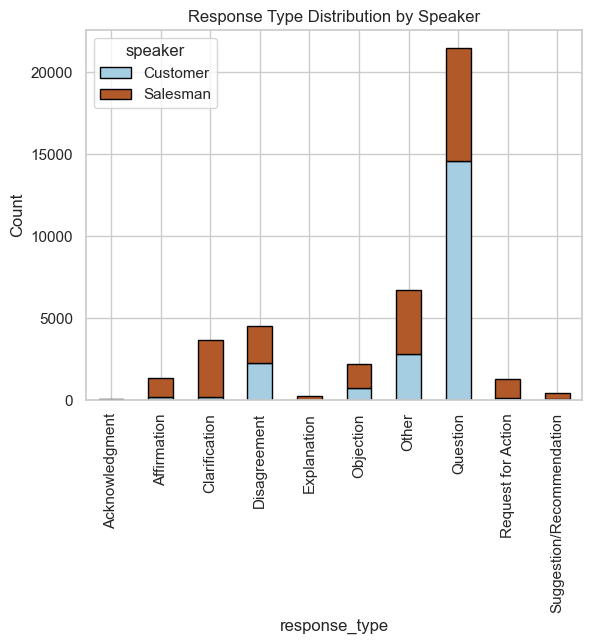

In [93]:
response_speaker_ct = pd.crosstab(df['response_type'], df['speaker'])
response_speaker_ct.plot(kind='bar', stacked=True, colormap="Paired", edgecolor="black")
plt.title("Response Type Distribution by Speaker")
plt.ylabel("Count")
plt.show()

**Observations**
* The Explanation response type is almost exclusively from the salesman, suggesting their role involves clarifying and elaborating.
* Customers tend to ask a lot of questions, indicating that the customers drive most of the conversation through inquiries, which contrasts well with our Explanation observation.
* The Objection response type mostly consists of customers, which aligns with their hesitation and concerns.
* Request for Action primarily consists of salesmen, which aligns with their goal of guiding the conversation towards actionable outcomes.

### sentiment_label by Speaker

Stacked bar chart: The distribution of sentiment_label (positive, neutral, negative) for each speaker

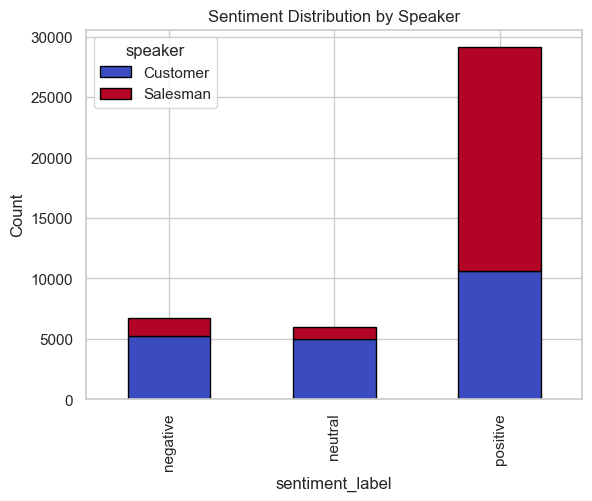

In [97]:
sentiment_speaker_ct = pd.crosstab(df['sentiment_label'], df['speaker'])
sentiment_speaker_ct.plot(kind='bar', stacked=True, colormap="coolwarm", edgecolor="black")
plt.title("Sentiment Distribution by Speaker")
plt.ylabel("Count")
plt.show()

**Observations**
* Most of the positive sentiment is captured by salesmen, which aligns with the optimistic tone needed for a customer-facing role.
* In contrast, salesmen rarely share negative sentiments. This also leaves most of the negative sentiment with the customer.
* Also aligning with the previous observations, neutral sentiment is mostly shared by the customer.

___

## Label Trends by Turn Position

In [112]:
# Function to plot label trends by turn position
def plot_label_trends(label_column, title):
    label_trends = df.groupby(['turn', label_column]).size().unstack(fill_value=0) # group by turn position
    label_trends = label_trends.div(label_trends.sum(axis=1), axis=0) # the proportion of each label at each turn
    
    label_trends.plot(kind='line', marker='o')
    plt.title(f"{title} Trends Over Conversation Turns")
    plt.xlabel("Turn Position")
    plt.ylabel("Proportion")
    plt.legend(title=label_column)
    plt.grid(True)
    plt.show()

### conversation_stage

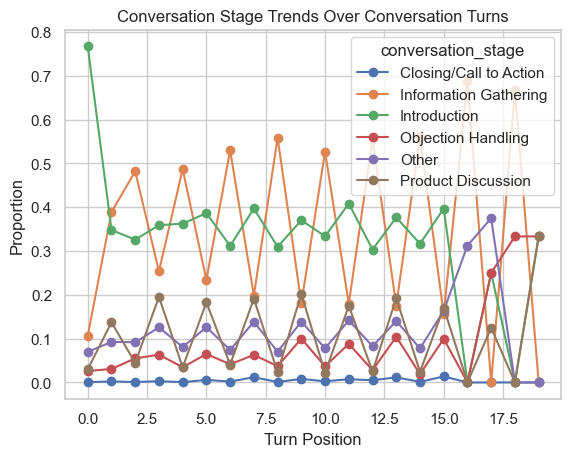

In [113]:
plot_label_trends('conversation_stage', "Conversation Stage")

**Observations**
* As expected, the Introduction stage has a very high proportion at Turn 0 and reaches its lowest at the end of the spectrum. It sharply decreases after the first turn and rarely appears afterward.
* Information Gathering is prominent and dominates most of the conversation. It has consistent peaks at various turn positions. This can reflect its important role in understanding the caller's needs.
* Objection Handling is fairly low but consistent. It can reflect points in the conversation where the speaker responds to concerns or talks about specific products.
* Closing/Call to Action is very minimal, which can mean that few conversations reach the closing stage or the labeling process needs to improve.
* The Other category is consistent but unclear.

### response_type

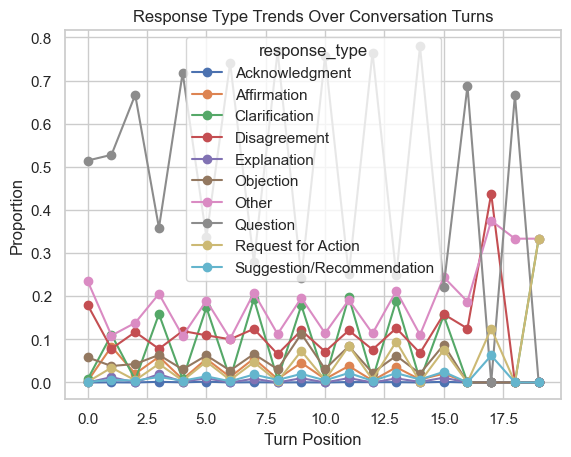

In [114]:
plot_label_trends('response_type', "Response Type")

**Observations**
* The Question type is the most frequent response type across almost all turns, which aligns with its role in gathering information and directing the dialogue.
* The Other category fluctuates, especially in the earlier and later turns. This further suggests ambiguous or unclassifiable responses at those points.
* Request for Action, Explanation, and Acknowledgement have low proportions, which may indicate a need for better labeling or just limited representation in the dataset.
* Clarification and Objection are consistently appearing but in small proportions. This can reflect points in the conversation that require resolution or concerns being addressed.
* Affirmation and Suggestion/Recommendation are steadily present but also low. This can point towards moments of agreement or guidance.

### sentiment_label

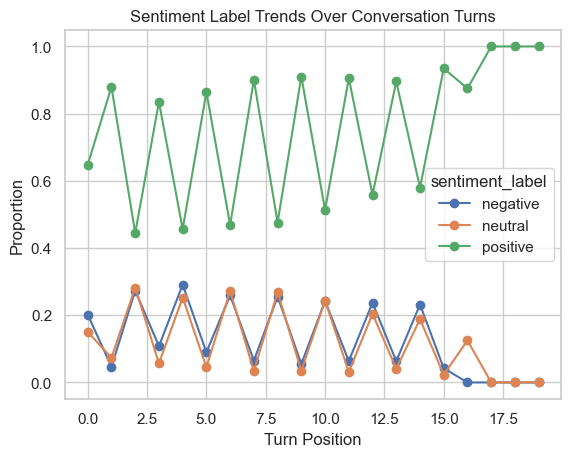

In [115]:
plot_label_trends('sentiment_label', "Sentiment Label")

**Observations**
* Positive sentiment is very dominant across all turn positions. This indicates that most of the conversation snippets are optimistic. This could also indicate that the dataset is skewed towards positive interactions, such as customer service goals.
* There is not much representation of negative and neutral sentiments, but they both fluctuate.
* As the positive proportion increases and decreases, the negative and neutral proportion does the inverse, aligning with expectations.

___

## Sentiment Analysis

### conversation_stage

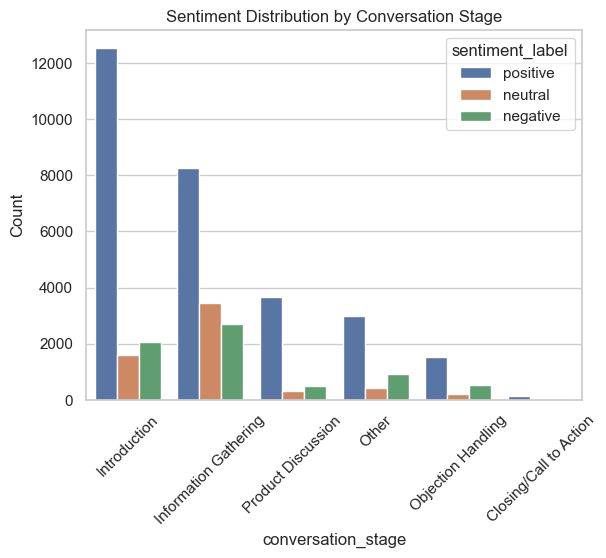

In [117]:
sns.countplot(data=df, x="conversation_stage", hue="sentiment_label")
plt.title("Sentiment Distribution by Conversation Stage")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

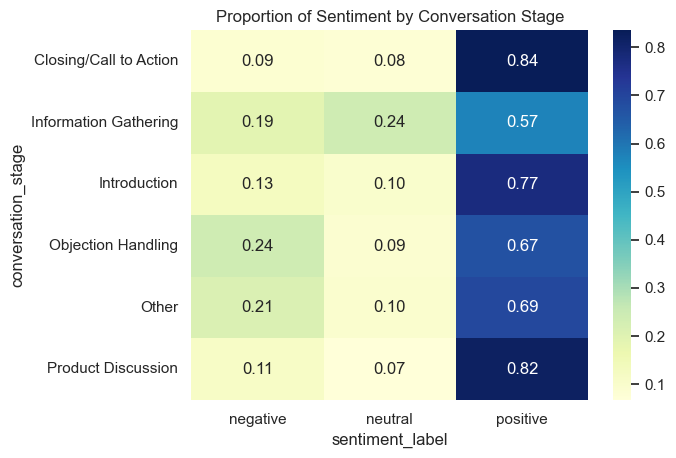

In [123]:
sentiment_stage = pd.crosstab(df['conversation_stage'], df['sentiment_label'], normalize='index')
sns.heatmap(sentiment_stage, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Proportion of Sentiment by Conversation Stage")
plt.show()

**Observations**
* Positive sentiment is notably high in the Introduction and Information Gathering stages. This aligns with the goal of creating a welcoming and productive space at the start of a conversation.
* Neutral sentiment is strong in the Information Gathering stage. This may be due to fact-based inquiries and clarifications during this stage.
* Negative sentiment peaks during Objection Handling. This is likely due to addressing concerns, doubts, or resistance.
* Closing/Call to Action has few datapoints, which was also reflected in earlier parts of this notebook.
* Product Discussion has a more even distriubtion of sentiments.

### response_type

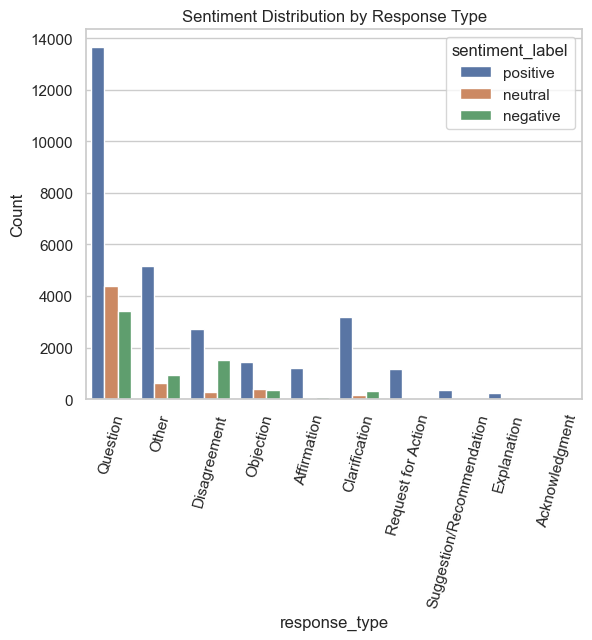

In [118]:
sns.countplot(data=df, x="response_type", hue="sentiment_label")
plt.title("Sentiment Distribution by Response Type")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.show()

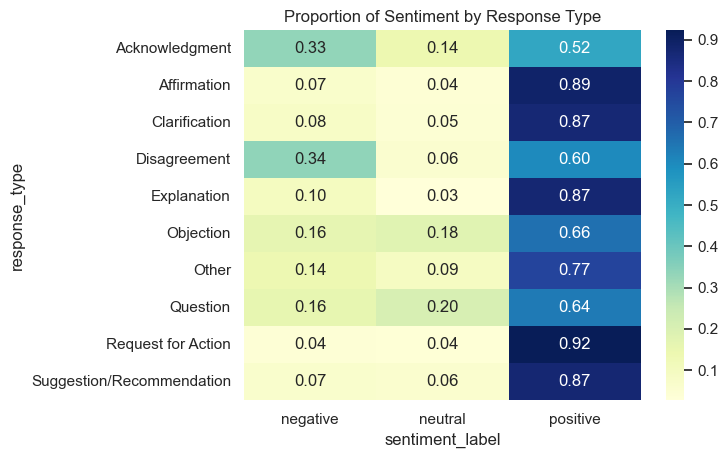

In [124]:
sentiment_response = pd.crosstab(df['response_type'], df['sentiment_label'], normalize='index')
sns.heatmap(sentiment_response, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Proportion of Sentiment by Response Type")
plt.show()

**Observations**
* Most questions have positive sentiment, which may indicate curiosity and constructive inquiries.
* Disagreement is skewed towards neutral and negative sentiment as expected.
* Objections also has a notable amount of negative sentiment as expected. 
* Naturally, affirmations are very positive.
* Clarifications also has a positive trend, reflecting a constructive and explanatory nature.
* The Other category is mixed and ambiguous.

___

## Common Words per Label

In [133]:
# stopwords handing

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def tokenize_and_filter(text):
    words = re.findall(r'\b\w+\b', text.lower())  # Extract words ignoring punctuation and case
    return [word for word in words if word not in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacquelinehong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### conversation_stage

In [134]:
# Top 10 words for each conversation_stage, excluding stopwords
common_words = {}
for label in df['conversation_stage'].unique():
    label_texts = df[df['conversation_stage'] == label]['text']
    all_words = [word for text in label_texts for word in tokenize_and_filter(text)]
    common_words[label] = [word for word, _ in Counter(all_words).most_common(10)]

pd.DataFrame(common_words)

,Introduction,Information Gathering,Product Discussion,Other,Objection Handling,Closing/Call to Action
0,im,im,product,im,concerns,demonstrate
1,product,specific,understand,understand,im,customer
2,interested,provide,let,absolutely,understand,needs
3,looking,product,provide,provide,provide,absolutely
4,financial,ive,customers,lets,address,listening
5,provide,understand,benefits,communication,lets,schedule
6,help,could,absolutely,financial,concern,understand
7,health,help,options,let,let,active
8,understand,health,products,important,sure,customers
9,specific,tell,health,make,feedback,im


**Observations**
* Introduction contains words like "im," "interested," "looking," "help," and "understand." This can indicate that customers initiate the conversations, and their purpose is to seek more information on the product.
* Information Gathering also contains similar words. This follows the theory that customers call to gather more information on the product. The salesman can also be gathering information on their needs.
* Product Discussion often contains words like "product," "customers," "benefits," and "options." The product may also be health-related and customers want to know about the benefits for their health.
* Objection Handling has words like "concerns," "address," and "financial." This can be for resolving hesitations and addressing issues.
* Closing/Call to Action has words like "demonstrate," "schedule," and "customers." This focuses on actionable next steps and finalizing the conversation and sale.

### response_type

In [135]:
# Top 10 words for each response_type, excluding stopwords
common_words = {}
for label in df['response_type'].unique():
    label_texts = df[df['response_type'] == label]['text']
    all_words = [word for text in label_texts for word in tokenize_and_filter(text)]
    common_words[label] = [word for word, _ in Counter(all_words).most_common(10)]

pd.DataFrame(common_words)

,Question,Other,Disagreement,Objection,Affirmation,Clarification,Request for Action,Suggestion/Recommendation,Explanation,Acknowledgment
0,im,im,im,concerns,course,understand,provide,considering,explain,see
1,product,product,sure,im,let,completely,absolutely,recommend,let,definitely
2,specific,absolutely,product,product,product,let,product,important,product,explore
3,provide,customers,health,investment,yes,product,customers,im,benefits,got
4,help,financial,interested,provide,provide,provide,financial,consider,absolutely,work
5,ive,let,understand,risk,health,concerns,benefits,lets,great,pain
6,tell,health,let,address,understand,lets,information,needs,unique,crashes
7,health,help,technology,lets,financial,concern,let,options,features,lets
8,interested,testimonials,provide,financial,make,customers,support,provide,value,options
9,understand,lets,absolutely,issues,time,needs,health,absolutely,detail,together


**Obsevations**
* Some labels show distinct and relevant words.
    * Objection shows "concerns," "risk," "investment," "address," "financial," and "issues."
    * Clarification shows "understand," "product," "provide," and "needs."
* Request for Action and Suggestion/Recommendation show actionable words, such as "provide," "support," and "recommend." This aligns with their intent.
* There is some overlap of common words, such as "let" and "im."
* Labels with less occurrences may be less distinct due to that limitation.

___

## Summary

1. **Sentiment Trends**
    * Positive sentiment dominates most stages and response types, aligning with customer service or sales-oriented settings.
    * Negative sentiment peaks in **Objection Handling**, indicating moments of resistance or dissatisfaction.
    * Neutral sentiment often appears in **Information Gathering,** likely due to fact-based or objective exchanges.
2. **Conversation Dynamics**
    * **Introduction** and **Information Gathering** are the most represented stages, with **Closing/Call to Action** underrepresented. This suggests that many conversations do not reach a final stage or successful conclusion.
    * **Questions** dominate the dataset, showing that conversations are largely inquiry-driven, while **Objection** and **Clarification** focus on **Product Discussion** and **Objection Handling**, aligning with their purposes.
3. **Speaker Roles**
    * Customers frequently ask **Questions** and express **Objections**, driving much of the conversation.
    * Salesmen primarily handle **Explanations** and **Requests for Action**, guiding the conversation and encouraging next steps to be taken.
    * Salesmen express more positive sentiments, while customers contribute more neutral and negative tones. This makes sense for their respective roles.
4. **Conversation Over Time (Turn Trends)**
    * **Introduction** is mostly seen at the beginning of conversations, while **Information Gathering** dominates the middle turns. This also aligns with expectations and can indicate useful labeling.
    * **Objection Handling** and **Closing/Call to Action** are more rare and scattered, possibly pointing to dataset or labeling limitations.
5. **Keyword Insights**
    * Keywords align well with stages and types, such as “concerns” in **Objection Handling** and “recommend” in **Suggestion/Recommendation**.
    * Common words like “im” and “let” appear across multiple labels. This suggests areas for label refinement.
6. **Label Challenges**
    * The **Other** category shows ambiguity and overlaps. This can make the distinctions between labels unclear.
    * Less common labels (eg. **Acknowledgment** or **Closing/Call to Action**) are less distinct, which may affect their usability.